In [1]:
from mtcnn.mtcnn import MTCNN
import cv2
from PIL import Image
from skimage import io
import os
import sys
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Alexander\.conda\envs\k

In [2]:
from collections import defaultdict
import itertools

In [3]:
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [4]:
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from keras.applications import resnet50
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, LeakyReLU, Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2
from keras.preprocessing import image
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import os
import numpy as np

In [5]:
batch_size = 16
epochs = 50

In [6]:
faceSize = (224, 224)
preprocessedDir = "faces"
labels = ['happy', 'sad', 'surprised', 'angry', 'disgust', 'fear']
labelsck = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
n_splits = 5

In [7]:
def cropImageSaving(filename, image, resultList, targetDir, saveroot):
    for i, result in enumerate(resultList):
        # Содержит box, confidence, keypoints
        x1, y1, x2, y2 = result['box']
        cropped = image.crop((x1, y1, x1 + x2, y1 + y2))
        cropped = cropped.resize(faceSize)
        newfilename = '.'.join(filename.split('.')[:-1]) + '_' + str(i) + '.jpg'
        cropped.save(os.path.join(targetDir, newfilename), "JPEG")
    if saveroot:
        i += 1
        newfilename = '.'.join(filename.split('.')[:-1]) + '_' + str(i) + '.jpg'
        image = image.resize(faceSize)
        image.save(os.path.join(targetDir, newfilename), "JPEG")

In [8]:
def cropImage(filename, image, resultList):
    faceList = []
    for i, result in enumerate(resultList):
        # Содержит box, confidence, keypoints
        x1, y1, x2, y2 = result['box']
        cropped = image.crop((x1, y1, x1 + x2, y1 + y2))
        cropped = cropped.resize(faceSize)
        faceList.append(cropped)
    '''if len(faceList) == 0:
        faceList.append(image)'''
    return faceList

In [9]:
'''filename = 'test1.jpg'
pixels = Image.open(filename)
detector = MTCNN()
faces = detector.detect_faces(np.asarray(pixels))
cropImageSaving(filename, faces, "./")'''

'filename = \'test1.jpg\'\npixels = Image.open(filename)\ndetector = MTCNN()\nfaces = detector.detect_faces(np.asarray(pixels))\ncropImageSaving(filename, faces, "./")'

In [10]:
detector = MTCNN()
def faceDetector(filename, srcDir, targetDir, facesDict = None, save = True, facesList = []):
    image = cv2.cvtColor(cv2.imread(os.path.join(srcDir, filename)), cv2.COLOR_BGR2RGB)
    #import time
    #start_time = time.time()
    faces = detector.detect_faces(image)
    #print("--- %s seconds ---" % (time.time() - start_time))
    if facesDict != None:
        facesDict[filename] = faces.copy()
    if save:
        if not os.path.exists(targetDir):
            os.makedirs(targetDir)
        cropImageSaving(filename, Image.fromarray(image), faces, targetDir, False)
    else:
        facesList += cropImage(filename, Image.fromarray(image), faces)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
detectorCK = MTCNN()
def faceDetectorCK(filename, srcDir, targetDir, facesDict = None, save = True, facesList = [], facesNames = []):
    image = cv2.cvtColor(cv2.imread(os.path.join(srcDir, filename)), cv2.COLOR_BGR2RGB)
    #import time
    #start_time = time.time()
    faces = detectorCK.detect_faces(image)
    #print("--- %s seconds ---" % (time.time() - start_time))
    if facesDict != None:
        facesDict[filename] = faces.copy()
    if save:
        if not os.path.exists(targetDir):
            os.makedirs(targetDir)
        for i in range(len(faces)):
            newfilename = '.'.join(filename.split('.')[:-1]) + '_' + str(i) + '.jpg'
            facesNames.append(newfilename)
            
        cropImageSaving(filename, Image.fromarray(image), faces, targetDir, False)
         
    else:
        facesList += cropImage(filename, Image.fromarray(image), faces)

In [12]:
def preprocess_input_vgg(y):
    x = y.copy()
    x = utils.preprocess_input(x, version = 1)
    x /= 255.
    return x

In [13]:
def preprocess_input_simple(y):
    x = y.copy()
    x /= 255.
    return x

In [14]:
def preprocess_input_vgg2(y):
    x = y.copy()
    x = utils.preprocess_input(x, version = 2)
    x /= 255.
    return x

In [15]:
def GCN_HE(y):
    y = cv2.equalizeHist(y)
    y = y.astype(np.float64)
    
    y_avg = np.mean(y)
    y = y - y_avg
    shift = 10
    contrast = np.sqrt(shift + np.mean(y ** 2))
    y = y / max(contrast, 0.001)
    
    return y

In [16]:
def preprocess_input_gray(y):
    gray = cv2.cvtColor(y.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    gray = GCN_HE(gray)
    x = np.zeros((*gray.shape, 3), dtype = np.float64)
    for i in range(3):
        x[:,:,i] = gray
    return x

In [17]:
def preprocess_input_colored(y):
    R, G, B = cv2.split(y.astype(np.uint8))
    
    R_new = GCN_HE(R)
    G_new = GCN_HE(G)
    B_new = GCN_HE(B)

    colored = cv2.merge((R_new, G_new, B_new))
    return colored

In [18]:
def frameExtraction(videoDir, framesDir, framesinsec):
    for videoname in os.listdir(videoDir):
        video = cv2.VideoCapture(os.path.join(videoDir, videoname))
        success, image = video.read()
        count = 0
        success = True
        print("Frame saving from " + os.path.join(videoDir, videoname))
        fps = int(video.get(cv2.CAP_PROP_FPS))
        if not os.path.exists(os.path.join(framesDir, videoname)):
            os.makedirs(os.path.join(framesDir, videoname))
        while success:
            cv2.imwrite(os.path.join(framesDir, videoname, "frame%d.jpg" % count), image)
            count += fps // framesinsec    
            video.set(cv2.CAP_PROP_POS_FRAMES, count)
            success, image = video.read()

In [19]:
def drawbbox(framesDir, facesDict):
    for framename in os.listdir(framesDir):
        if framename != preprocessedDir:
            frame = cv2.imread(os.path.join(framesDir, framename))
            faces = facesDict[framename]
            for i, result in enumerate(faces):
                x1, y1, x2, y2 = result['box']
                print(x1, y1, x2, y2)
                cv2.rectangle(frame, (x1, y1), (x1 + x2, y1 + y2), (255, 0, 0), 2) 
            cv2.imwrite(os.path.join(framesDir, framename), frame)

In [20]:
def bboxLabels(framesDir, facesDict, predictions, labelsArr):
    j = 0
    for framename in sorted(os.listdir(framesDir)):
        if framename != preprocessedDir:
            frame = cv2.imread(os.path.join(framesDir, framename))
            faces = facesDict[framename]
            for i, result in enumerate(faces):
                x1, y1, x2, y2 = result['box']
                cv2.rectangle(frame, (x1, y1), (x1 + x2, y1 + y2), (255, 0, 0), 2) 
                cv2.putText(frame, labelsArr[int(predictions[j])], (x1, y1 + y2), 1, 1.5, (255, 0, 0))
                j += 1
            cv2.imwrite(os.path.join(framesDir, framename), frame)

In [ ]:
frameExtraction('videos', 'frames', 10)
facesDict = defaultdict(list)
for f in os.listdir('frames/FHD0011.MOV'):
    if f != preprocessedDir:
        faceDetector(f, 'frames/FHD0011.MOV', 'frames/FHD0011.MOV/faces', facesDict)

In [ ]:
drawbbox('frames/FHD0011.MOV', facesDict)

In [ ]:
print(facesDict)

In [89]:
drawbbox('frames/classroomGoogle_Trim.mp4', facesDict)

669 16 120 166
772 8 228 267
28 74 140 185
355 109 100 143
672 17 116 164
794 -2 216 257
356 104 105 150
39 72 136 178
671 15 120 168
798 -12 215 265
356 103 107 151
36 73 131 180
792 -10 216 261
671 22 117 162
32 74 135 183
354 100 100 152
777 -15 210 255
669 20 116 168
37 80 127 178
351 98 104 155
756 -24 213 266
671 20 119 169
45 88 125 168
353 100 103 155
767 -18 198 250
679 18 124 171
42 81 129 181
365 104 123 151
767 -13 198 247
681 17 122 170
36 86 142 189
364 104 99 146
767 -5 206 237
685 16 123 171
59 92 129 171
-22 105 179 264
367 99 101 154
224 358 72 84
802 -5 220 237
701 23 116 165
-10 102 190 257
383 104 116 150
-5 113 181 248
707 21 118 166
827 -12 231 253
394 106 93 135
21 111 197 262
728 20 117 164
873 -5 222 245
413 104 93 137
58 126 186 248
741 19 117 164
887 -6 222 249
426 106 92 138
50 122 192 250
749 18 119 163
895 -16 222 259
430 103 100 142
53 111 191 254
898 -19 222 265
767 -4 124 174
446 106 110 141
57 102 192 257
899 -14 220 265
783 -7 129 160
451 101 96 143


In [21]:
def getSimpleModel():
    inputLayer = Input(shape = (*faceSize, 3))
    l = Conv2D(64, kernel_size=4, activation='relu')(inputLayer)
    l = MaxPooling2D(pool_size=(2, 2))(l)
    l = Dropout(0.3)(l)
    l = Conv2D(64, kernel_size=4, activation='relu')(inputLayer)
    l = MaxPooling2D(pool_size=(2, 2))(l)
    l = Dropout(0.3)(l)
    l = Conv2D(4, kernel_size=4, activation='relu')(l)
    l = MaxPooling2D(pool_size=(2, 2))(l)
    l = Flatten()(l)
    l = Dense(512, kernel_regularizer=l2(0.003))(l)
    l = LeakyReLU()(l)
    l = Dropout(0.5)(l)
    l = Dense(128, kernel_regularizer=l2(0.003))(l)
    l = LeakyReLU()(l)
    l = Dropout(0.5)(l)
    l = Dense(6, activation='softmax')(l)
    model = Model(inputs=inputLayer, outputs=l)
    return model

In [22]:
def getCNNModel(num_features):
    model = Sequential()

    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(*faceSize, 3), data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(2*2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*num_features, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(6, activation='softmax'))
    return model

In [23]:
def getVGGFaceModel(outlen = 6):
    features_model = VGGFace(include_top = False, input_shape = (*faceSize, 3), pooling = 'avg')
    l = features_model.output
    #l = GlobalAveragePooling2D()(l)
    l = Dense(2048, kernel_regularizer=l2(0.005))(l)
    l = LeakyReLU()(l)
    l = BatchNormalization()(l)
    l = Dropout(0.5)(l)
    l = Dense(1024, kernel_regularizer=l2(0.005))(l)
    l = LeakyReLU()(l)
    l = BatchNormalization()(l)
    l = Dropout(0.5)(l)
    l = Dense(outlen, activation='softmax')(l)
    model = Model(inputs=features_model.input, outputs=l)
    for l in features_model.layers:
        l.trainable = False
    return model

In [24]:
def getVGGCKModel():
    return getVGGFaceModel(len(labelsck))

In [25]:
def getVGGFace2Model():
    features_model = VGGFace(model='senet50', include_top = False, input_shape = (*faceSize, 3), pooling = 'avg')
    l = features_model.output
    #l = Flatten()(l)
    l = Dense(1024, kernel_regularizer=l2(0.003))(l)
    l = LeakyReLU()(l)
    l = Dropout(0.5)(l)
    l = Dense(1024, kernel_regularizer=l2(0.003))(l)
    l = LeakyReLU()(l)
    l = Dense(6, activation='softmax')(l)
    model = Model(inputs=features_model.input, outputs=l)
    for l in features_model.layers:
        l.trainable = False
    return model

In [26]:
def getVGGSVMModel():
    f = VGGFace(model = 'senet50', include_top = False, input_shape = (*faceSize, 3), pooling = 'avg')
    return f

In [27]:
def jaffeFaces():
    datasetDir = 'jaffedbase'
    trainDir = os.path.join(datasetDir, preprocessedDir)
    if not os.path.exists(trainDir):
        os.makedirs(trainDir)
        for f in os.listdir(datasetDir):
            if f != preprocessedDir:
                faceDetector(f, datasetDir, trainDir)

In [28]:
def ckFaces():
    datasetDir = 'ckplus'
    gt_dict = {}
    trainDir = os.path.join(datasetDir, preprocessedDir)
    if not os.path.exists(trainDir):
        os.makedirs(trainDir)
        for s in os.listdir(datasetDir):
            if s != preprocessedDir and s.split('.')[-1] != 'txt':
                for t in os.listdir(os.path.join(datasetDir, s)):
                    #neutral = False
                    for f in sorted(os.listdir(os.path.join(datasetDir, s, t))):
                        if f.split('.')[-1] == 'txt':
                            gt = open(os.path.join(datasetDir, s, t, f), "r")
                            name = '_'.join('.'.join(f.split('.')[:-1]).split('_')[:-1])
                            name = '.'.join([name, 'png'])
                            line = gt.read()
                            value = int(float(line.strip()))
                            gt.close()
                            facesNames = []
                            faceDetectorCK(name, os.path.join(datasetDir, s, t), trainDir, facesNames = facesNames)
                            for p in facesNames:
                                gt_dict[p] = value - 1 #-1 if no neutral
                        '''elif not neutral:
                            facesNames = []
                            faceDetectorCK(f, os.path.join(datasetDir, s, t), trainDir, facesNames = facesNames)
                            for p in facesNames:
                                gt_dict[p] = 0
                            neutral = True'''
        gt_file = open(os.path.join(datasetDir, 'gt.txt'), "w")
        for key in gt_dict:
            gt_file.write(f"{key}-{gt_dict[key]}\n")
        gt_file.close()

In [29]:
def train(datasetDir, gtFile, modelFunc, preprocessFunc, outputName, preprocess = True):
    trainDir = os.path.join(datasetDir, preprocessedDir)
    if preprocess:
        jaffeFaces()
    
    length = len(os.listdir(trainDir))
    
    trainTxt = open(gtFile, "r")
    trainData = {}
    
    for line in trainTxt:
        values = line.split(' ')
        fvalues = [float(v) for v in values[1:7]]
        #trainData[values[0]] = [1 if v == max(fvalues) else 0 for v in fvalues]
        trainData[values[0]] = fvalues
    
    model = modelFunc()
    print(model.summary())
    
    '''for l in features_model.layers:
        l.trainable = False'''
        
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    Y = np.zeros((length, 6))
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(os.listdir(trainDir)):
        id = (f.split('.')[2]).split('_')[0]
        image = io.imread(os.path.join(trainDir, f))
        imageArray = preprocessFunc(image.astype(np.float64))
        X[i] = imageArray.copy()
        Y[i][np.argmax(trainData[id])] = 1
        
    #splitting into training, validation and testing data
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
    
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_data=(X_val, Y_val))

    model.save(outputName)

In [30]:
def trainCK(datasetDir, gtFile, modelFunc, preprocessFunc, outputName, preprocess = True):
    trainDir = os.path.join(datasetDir, preprocessedDir)
    if preprocess:
        ckFaces()
    
    length = len(os.listdir(trainDir))
    
    trainTxt = open(gtFile, "r")
    trainData = {}
    
    for line in trainTxt:
        pair = line.split('-')
        trainData[pair[0]] = pair[1]
    
    Y = np.zeros((length, len(labelsck)))
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(os.listdir(trainDir)):
        image = io.imread(os.path.join(trainDir, f))
        imageArray = preprocessFunc(image.astype(np.float64))
        X[i] = imageArray.copy()
        Y[i][int(trainData[f])] = 1
    
    model = modelFunc()
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X, Y, batch_size=batch_size, epochs=epochs)
    
    model.save(outputName)

In [31]:
def trainSVM(datasetDir, gtFile, modelFunc, preprocessFunc, preprocess = True):
    trainDir = os.path.join(datasetDir, preprocessedDir)
    if preprocess:
        ckFaces()
    
    length = len(os.listdir(trainDir))
    
    trainTxt = open(gtFile, "r")
    trainData = {}
    
    for line in trainTxt:
        pair = line.split('-')
        trainData[pair[0]] = pair[1]
    
    Y = np.zeros(length)
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(os.listdir(trainDir)):
        image = io.imread(os.path.join(trainDir, f))
        imageArray = preprocessFunc(image.astype(np.float64))
        X[i] = imageArray.copy()
        Y[i] = int(trainData[f])
    
    featureModel = modelFunc()
    featuresTrain = featureModel.predict(X)
    
    cls = svm.SVC(kernel='rbf', C=100.0, gamma=0.07, cache_size=800)
    cls.fit(featuresTrain, Y)
    
    return cls

In [32]:
def trainSVMFacesProb(datasetDir, gtFile, modelFunc, preprocessFunc, preprocess = True):
    trainDir = os.path.join(datasetDir, preprocessedDir)
    if preprocess:
        ckFaces()
    
    length = len(os.listdir(trainDir))
    
    trainTxt = open(gtFile, "r")
    trainData = {}
    
    for line in trainTxt:
        pair = line.split('-')
        trainData[pair[0]] = pair[1]
    
    Y = np.zeros(length)
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(os.listdir(trainDir)):
        image = io.imread(os.path.join(trainDir, f))
        imageArray = preprocessFunc(image.astype(np.float64))
        X[i] = imageArray.copy()
        Y[i] = int(trainData[f])
    
    featureModel = modelFunc()
    featuresTrain = featureModel.predict(X)
    
    cls = svm.SVC(kernel='rbf', C=100.0, gamma=0.07, cache_size=800, probability = True)
    cls.fit(featuresTrain, Y)
    
    return cls

In [33]:
def trainSimple(datasetDir, gtFile, preprocess = True):
    trainDir = datasetDir
    if preprocess:
        trainDir = os.path.join(datasetDir, preprocessedDir)
        if not os.path.exists(trainDir):
            os.makedirs(trainDir)
            for f in os.listdir(datasetDir):
                if f != preprocessedDir:
                    faceDetector(f, datasetDir, trainDir)
    
    length = len(os.listdir(trainDir))
    
    trainTxt = open(gtFile, "r")
    trainData = {}
    
    for line in trainTxt:
        values = line.split(' ')
        fvalues = [float(v) for v in values[1:7]]
        #trainData[values[0]] = [1 if v == max(fvalues) else 0 for v in fvalues]
        trainData[values[0]] = fvalues
    
    model = getSimpleModel()
    print(model.summary())
    
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    Y = np.zeros((length, 6))
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(os.listdir(trainDir)):
        id = (f.split('.')[2]).split('_')[0]
        image = io.imread(os.path.join(trainDir, f))
        imageArray = preprocess_input_simple(image.astype(np.float64))
        X[i] = imageArray.copy()
        Y[i][np.argmax(trainData[id])] = 1
        
    #splitting into training, validation and testing data
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
    
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_data=(X_val, Y_val))

    model.save('facesSimple.hdf5')

In [34]:
train("jaffedbase", "gt.txt", getVGGFaceModel, preprocess_input_simple, 'facesVGG.hdf5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
___________________________

KeyboardInterrupt: 

In [34]:
train("jaffedbase", "gt.txt", getVGGFace2Model, preprocess_input_vgg2, 'facesVGG2.hdf5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_9[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

Train on 191 samples, validate on 22 samples
Epoch 1/50
191/191 [==============================] - 4s 22ms/step - loss: 16.2800 - acc: 0.2775 - val_loss: 18.6836 - val_acc: 0.1364
Epoch 2/50
191/191 [==============================] - 1s 4ms/step - loss: 17.6487 - acc: 0.3455 - val_loss: 19.6568 - val_acc: 0.2273
Epoch 3/50
191/191 [==============================] - 1s 3ms/step - loss: 19.1437 - acc: 0.2565 - val_loss: 19.5526 - val_acc: 0.2273
Epoch 4/50
191/191 [==============================] - 1s 3ms/step - loss: 19.0107 - acc: 0.2565 - val_loss: 19.3917 - val_acc: 0.2273
Epoch 5/50
191/191 [==============================] - 1s 4ms/step - loss: 18.8349 - acc: 0.2565 - val_loss: 19.2016 - val_acc: 0.2273
Epoch 6/50
191/191 [==============================] - 1s 4ms/step - loss: 18.6371 - acc: 0.2565 - val_loss: 18.9964 - val_acc: 0.2273
Epoch 7/50
191/191 [==============================] - 1s 3ms/step - loss: 18.4278 - acc: 0.2565 - val_loss: 18.7831 - val_acc: 0.2273
Epoch 8/50
191/1

KeyboardInterrupt: 

In [49]:
trainSimple("jaffedbase", "gt.txt")

--- 0.1276838779449463 seconds ---
--- 0.0343475341796875 seconds ---
--- 0.031250715255737305 seconds ---
--- 0.03125286102294922 seconds ---
--- 0.04687190055847168 seconds ---
--- 0.03125 seconds ---
--- 0.02603316307067871 seconds ---
--- 0.031253814697265625 seconds ---
--- 0.03124856948852539 seconds ---
--- 0.031250953674316406 seconds ---
--- 0.0312502384185791 seconds ---
--- 0.02502894401550293 seconds ---
--- 0.03125333786010742 seconds ---
--- 0.015624284744262695 seconds ---
--- 0.03118419647216797 seconds ---
--- 0.029000043869018555 seconds ---
--- 0.02702951431274414 seconds ---
--- 0.031253814697265625 seconds ---
--- 0.04033708572387695 seconds ---
--- 0.026999473571777344 seconds ---
--- 0.026764869689941406 seconds ---
--- 0.036165714263916016 seconds ---
--- 0.035997629165649414 seconds ---
--- 0.0279996395111084 seconds ---
--- 0.0381467342376709 seconds ---
--- 0.03300046920776367 seconds ---
--- 0.03508806228637695 seconds ---
--- 0.03297877311706543 seconds ---

KeyboardInterrupt: 

In [106]:
trainCK('ckplus', 'ckplus/gt.txt', getVGGCKModel, preprocess_input_gray, 'modelCK.hdf5')

Epoch 1/50
328/328 [==============================] - 4s 11ms/step - loss: 12.6048 - acc: 0.6280
Epoch 2/50
328/328 [==============================] - 1s 4ms/step - loss: 11.1750 - acc: 0.8750
Epoch 3/50
328/328 [==============================] - 1s 4ms/step - loss: 10.5285 - acc: 0.9116
Epoch 4/50
328/328 [==============================] - 1s 4ms/step - loss: 10.1062 - acc: 0.8963
Epoch 5/50
328/328 [==============================] - 1s 4ms/step - loss: 9.2677 - acc: 0.9299
Epoch 6/50
328/328 [==============================] - 1s 4ms/step - loss: 8.6791 - acc: 0.9390
Epoch 7/50
328/328 [==============================] - 1s 4ms/step - loss: 8.0880 - acc: 0.9390
Epoch 8/50
328/328 [==============================] - 1s 4ms/step - loss: 7.5540 - acc: 0.9299
Epoch 9/50
328/328 [==============================] - 1s 4ms/step - loss: 7.1085 - acc: 0.9329
Epoch 10/50
328/328 [==============================] - 1s 4ms/step - loss: 6.6154 - acc: 0.9207
Epoch 11/50
328/328 [=======================

In [47]:
clsSVM = trainSVM('ckplus', 'ckplus/gt.txt', getVGGSVMModel, preprocess_input_colored)

In [54]:
def predict(testDir, facesDict, modelFunc, preprocessFunc, inputName):
    model = modelFunc()
    model.load_weights(inputName)
    
    facesList = []
    
    for f in sorted(os.listdir(testDir)):
        if f != preprocessedDir:
            faceDetector(f, testDir, None, facesDict, False, facesList)
    
    length = len(facesList)
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(facesList):
        imageArray = preprocessFunc((np.asarray(f)).astype(np.float64))
        X[i] = imageArray.copy()
        
    Y = model.predict(X)
    return Y

In [55]:
def predictSVM(testDir, facesDict, modelFunc, preprocessFunc, cls):
    featureModel = modelFunc()
    
    facesList = []
    
    for f in sorted(os.listdir(testDir)):
        if f != preprocessedDir:
            faceDetector(f, testDir, None, facesDict, False, facesList)
    
    length = len(facesList)
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(facesList):
        imageArray = preprocessFunc((np.asarray(f)).astype(np.float64))
        X[i] = imageArray.copy()
    
    featuresTrain = featureModel.predict(X)
    print(featuresTrain.shape)
    Y = cls.predict(featuresTrain)
    return Y

In [107]:
frameExtraction('videos', 'frames', 10)

Frame saving from videos\classroomGoogle_Trim.mp4


In [59]:
#NN
facesDict = defaultdict(list)
preds = predict('test', facesDict, getVGGCKModel, preprocess_input_gray, 'modelCK.hdf5')
predictions = []
for p in preds:
    predictions.append(np.argmax(p))

NameError: name 'pp' is not defined

In [50]:
#SVM
facesDict = defaultdict(list)
predictions = predictSVM('test', facesDict, getVGGSVMModel, preprocess_input_colored, clsSVM)

(12, 512)


In [44]:
bboxLabels('test', facesDict, predictions, labelsck)

In [51]:
for p in predictions:
    print(p)

[0.16724678 0.04881189 0.27362686 0.10011003 0.09803685 0.05264652
 0.25952108]
[0.06200614 0.01270776 0.5540237  0.03913033 0.05059153 0.05948106
 0.22205948]
[0.15164555 0.01133924 0.13774783 0.14804322 0.06104481 0.09813532
 0.39204403]
[0.12199633 0.01985456 0.16197995 0.10991506 0.05712947 0.0352701
 0.49385452]
[0.15644084 0.02216264 0.27993735 0.12484419 0.07915633 0.06609828
 0.27136038]
[0.2819689  0.02237688 0.25400059 0.12090812 0.07977986 0.05782992
 0.18313573]
[0.2903605  0.01656523 0.28309871 0.07232889 0.05888791 0.04505535
 0.23370339]
[0.08371232 0.027761   0.30167849 0.21808868 0.10667002 0.02661782
 0.23547167]
[0.14125395 0.00690793 0.30979169 0.06245213 0.03643233 0.02320338
 0.41995858]
[0.25817696 0.01127384 0.23689073 0.05054277 0.03144055 0.0478746
 0.36380054]
[0.1543782  0.01175576 0.30217058 0.0531032  0.03217577 0.04423155
 0.40218495]
[0.16131609 0.00934062 0.26092671 0.1114861  0.04682837 0.04390365
 0.36619846]


In [56]:
unique, counts = np.unique(predictions, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 1433, 2.0: 1117, 3.0: 2, 5.0: 1, 6.0: 8166}


In [56]:
def crossvalSimple(datasetDir, gtFile, preprocess = True):
    trainDir = datasetDir
    if preprocess:
        trainDir = os.path.join(datasetDir, preprocessedDir)
        if not os.path.exists(trainDir):
            os.makedirs(trainDir)
            for f in os.listdir(datasetDir):
                if f != preprocessedDir:
                    faceDetector(f, datasetDir, trainDir)
    
    length = len(os.listdir(trainDir))
    
    trainTxt = open(gtFile, "r")
    trainData = {}
    
    for line in trainTxt:
        values = line.split(' ')
        fvalues = [float(v) for v in values[1:7]]
        #trainData[values[0]] = [1 if v == max(fvalues) else 0 for v in fvalues]
        trainData[values[0]] = fvalues
    
    Y = np.zeros(length)
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(os.listdir(trainDir)):
        id = (f.split('.')[2]).split('_')[0]
        image = io.imread(os.path.join(trainDir, f))
        imageArray = preprocess_input_simple(image.astype(np.float64))
        X[i] = imageArray.copy()
        Y[i] = np.argmax(trainData[id])
        
    kfold = StratifiedKFold(n_splits = n_splits, shuffle = True)
    scores = []
    
    for train, test in kfold.split(X, Y):
        model = getSimpleModel()
        optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        ytrain = np.zeros((len(Y[train]), 6))
        for i in range(len(Y[train])):
            ytrain[i][int(Y[train][i])] = 1
        ytest = np.zeros((len(Y[test]), 6))
        for i in range(len(Y[test])):
            ytest[i][int(Y[test][i])] = 1
        model.fit(X[train], ytrain, batch_size=batch_size, epochs=epochs)
        score = model.evaluate(X[test], ytest)
        scores.append(score)
        
    return scores

In [57]:
def crossval(datasetDir, gtFile, modelFunc, preprocessFunc, preprocess = True):
    trainDir = datasetDir
    trainDir = os.path.join(datasetDir, preprocessedDir)
    if preprocess:
        jaffeFaces()
    
    length = len(os.listdir(trainDir))
    
    trainTxt = open(gtFile, "r")
    trainData = {}
    
    for line in trainTxt:
        values = line.split(' ')
        fvalues = [float(v) for v in values[1:7]]
        #trainData[values[0]] = [1 if v == max(fvalues) else 0 for v in fvalues]
        trainData[values[0]] = fvalues
    
    Y = np.zeros(length)
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(os.listdir(trainDir)):
        id = (f.split('.')[2]).split('_')[0]
        image = io.imread(os.path.join(trainDir, f))
        imageArray = preprocessFunc(image.astype(np.float64))
        X[i] = imageArray.copy()
        Y[i] = np.argmax(trainData[id])
        
    kfold = StratifiedKFold(n_splits = n_splits, shuffle = True)
    scores = []
    conf = []
    
    for train, test in kfold.split(X, Y):
        model = modelFunc()
        optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        ytrain = np.zeros((len(Y[train]), 6))
        for i in range(len(Y[train])):
            ytrain[i][int(Y[train][i])] = 1
        ytest = np.zeros((len(Y[test]), 6))
        for i in range(len(Y[test])):
            ytest[i][int(Y[test][i])] = 1
        model.fit(X[train], ytrain, batch_size=batch_size, epochs=epochs)
        score = model.evaluate(X[test], ytest)
        yt = model.predict(X[test])
        ypred = np.zeros(yt.shape)
        for i in range(yt.shape[0]):
            ypred[i][np.argmax(yt[i])] = 1
        scores.append(score)
        conf.append([ypred.copy(), ytest.copy()])
        
    return scores, conf

In [58]:
def crossvalSVM(datasetDir, gtFile, modelFunc, preprocessFunc, preprocess = True):    
    trainDir = datasetDir
    trainDir = os.path.join(datasetDir, preprocessedDir)
    if preprocess:
        jaffeFaces()
    
    length = len(os.listdir(trainDir))
    
    trainTxt = open(gtFile, "r")
    trainData = {}
    
    for line in trainTxt:
        values = line.split(' ')
        fvalues = [float(v) for v in values[1:7]]
        #trainData[values[0]] = [1 if v == max(fvalues) else 0 for v in fvalues]
        trainData[values[0]] = fvalues
    
    Y = np.zeros(length)
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(os.listdir(trainDir)):
        id = (f.split('.')[2]).split('_')[0]
        image = io.imread(os.path.join(trainDir, f))
        imageArray = preprocessFunc(image.astype(np.float64))
        X[i] = imageArray.copy()
        Y[i] = np.argmax(trainData[id])
        
    kfold = StratifiedKFold(n_splits = n_splits, shuffle = True)
    scores = []
    conf = []
    
    for train, test in kfold.split(X, Y):
        model = modelFunc()
            
        featuresTrain = model.predict(X[train])
        featuresTest = model.predict(X[test])
        
        '''ytall = np.zeros(Y[test].shape)
        for i in range(6):
            cls = svm.SVC(kernel='rbf',C=100.0,gamma=0.07,cache_size=800)
            ytrain = np.zeros(Y[train].shape)
            for j in range(Y[train].shape[0]):
                if Y[train][j] == i:
                    ytrain[j] = 1
            cls.fit(featuresTrain, ytrain)
            yt = cls.predict(featuresTest)
            for j in range(yt.shape[0]):
                if ytall[j] == 0:
                    ytall[j] = yt[j] * i'''
        cls = svm.SVC(kernel='rbf',C=100.0,gamma=0.07,cache_size=800)
        cls.fit(featuresTrain, Y[train])
        yt = cls.predict(featuresTest)
        score = cls.score(featuresTest, Y[test])
        scores.append(score)
        
        conf.append([yt.copy(), Y[test].copy()])
        
    return scores, conf

In [42]:
scoresVGG, confVGG = crossval("jaffedbase", "gt.txt", getVGGFaceModel, preprocess_input_vgg)

Epoch 1/100
168/168 [==============================] - 3s 18ms/step - loss: 13.4407 - acc: 0.4702
Epoch 2/100
168/168 [==============================] - 1s 4ms/step - loss: 11.7107 - acc: 0.7321
Epoch 3/100
168/168 [==============================] - 1s 4ms/step - loss: 11.3545 - acc: 0.7679
Epoch 4/100
168/168 [==============================] - 1s 4ms/step - loss: 10.7513 - acc: 0.8274
Epoch 5/100
168/168 [==============================] - 1s 4ms/step - loss: 10.1713 - acc: 0.8631
Epoch 6/100
168/168 [==============================] - 1s 4ms/step - loss: 9.8254 - acc: 0.8452
Epoch 7/100
168/168 [==============================] - 1s 4ms/step - loss: 9.4051 - acc: 0.8452
Epoch 8/100
168/168 [==============================] - 1s 4ms/step - loss: 9.0430 - acc: 0.8214
Epoch 9/100
168/168 [==============================] - 1s 4ms/step - loss: 8.7944 - acc: 0.8155
Epoch 10/100
168/168 [==============================] - 1s 4ms/step - loss: 8.2932 - acc: 0.8750
Epoch 11/100
168/168 [===========

170/170 [==============================] - 1s 4ms/step - loss: 1.7219 - acc: 0.9412
Epoch 70/100
170/170 [==============================] - 1s 4ms/step - loss: 1.5895 - acc: 0.9647
Epoch 71/100
170/170 [==============================] - 1s 4ms/step - loss: 1.7232 - acc: 0.9412
Epoch 72/100
170/170 [==============================] - 1s 4ms/step - loss: 1.6614 - acc: 0.9235
Epoch 73/100
170/170 [==============================] - 1s 4ms/step - loss: 1.5827 - acc: 0.9471
Epoch 74/100
170/170 [==============================] - 1s 4ms/step - loss: 1.5035 - acc: 0.9412
Epoch 75/100
170/170 [==============================] - 1s 4ms/step - loss: 1.6807 - acc: 0.9000
Epoch 76/100
170/170 [==============================] - 1s 4ms/step - loss: 1.7147 - acc: 0.9000
Epoch 77/100
170/170 [==============================] - 1s 4ms/step - loss: 1.6494 - acc: 0.9118
Epoch 78/100
170/170 [==============================] - 1s 4ms/step - loss: 1.7454 - acc: 0.9000
Epoch 79/100
170/170 [=====================

171/171 [==============================] - 1s 4ms/step - loss: 3.2273 - acc: 0.9064
Epoch 36/100
171/171 [==============================] - 1s 4ms/step - loss: 3.0919 - acc: 0.9474
Epoch 37/100
171/171 [==============================] - 1s 4ms/step - loss: 3.0490 - acc: 0.9123
Epoch 38/100
171/171 [==============================] - 1s 4ms/step - loss: 2.9107 - acc: 0.9532
Epoch 39/100
171/171 [==============================] - 1s 4ms/step - loss: 2.8397 - acc: 0.9298
Epoch 40/100
171/171 [==============================] - 1s 4ms/step - loss: 2.8983 - acc: 0.9298
Epoch 41/100
171/171 [==============================] - 1s 4ms/step - loss: 2.8166 - acc: 0.9123
Epoch 42/100
171/171 [==============================] - 1s 4ms/step - loss: 2.5590 - acc: 0.9532
Epoch 43/100
171/171 [==============================] - 1s 4ms/step - loss: 2.5699 - acc: 0.9298
Epoch 44/100
171/171 [==============================] - 1s 4ms/step - loss: 2.5646 - acc: 0.9181
Epoch 45/100
171/171 [=====================

173/173 [==============================] - 1s 4ms/step - loss: 5.3032 - acc: 0.9595
Epoch 20/100
173/173 [==============================] - 1s 4ms/step - loss: 5.2593 - acc: 0.9133
Epoch 21/100
173/173 [==============================] - 1s 4ms/step - loss: 5.0269 - acc: 0.9249
Epoch 22/100
173/173 [==============================] - 1s 4ms/step - loss: 4.6420 - acc: 0.9480
Epoch 23/100
173/173 [==============================] - 1s 4ms/step - loss: 4.5008 - acc: 0.9422
Epoch 24/100
173/173 [==============================] - 1s 4ms/step - loss: 4.5150 - acc: 0.8902
Epoch 25/100
173/173 [==============================] - 1s 4ms/step - loss: 4.3683 - acc: 0.9017
Epoch 26/100
173/173 [==============================] - 1s 5ms/step - loss: 3.9763 - acc: 0.9422
Epoch 27/100
173/173 [==============================] - 1s 4ms/step - loss: 3.9625 - acc: 0.8960
Epoch 28/100
173/173 [==============================] - 1s 4ms/step - loss: 3.9706 - acc: 0.8960
Epoch 29/100
173/173 [=====================

In [ ]:
scoresVGG2 = crossval("jaffedbase", "gt.txt", getVGGFace2Model, preprocess_input_vgg2)

C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Epoch 1/50


In [47]:
scoresVGGSVM, confVGGSVM = crossvalSVM("jaffedbase", "gt.txt", getVGGSVMModel, preprocess_input_vgg)

In [39]:
def getCNNModelN():
    return getCNNModel(16)
scoresCNN, confCNN = crossval("jaffedbase", "gt.txt", getCNNModelN, preprocess_input_simple)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50


KeyboardInterrupt: 

In [35]:
print(scores)

[[2.669023036956787, 0.6666666865348816], [3.3894264698028564, 0.5909090638160706], [1.7140320539474487, 0.27272728085517883], [1.87248694896698, 0.6190476417541504], [3.293524742126465, 0.5], [1.7206991910934448, 0.2380952388048172], [1.7216135263442993, 0.2380952388048172], [2.585045576095581, 0.4761904776096344], [1.6595255136489868, 0.8095238208770752], [1.3964406251907349, 0.699999988079071]]


In [49]:
print(scoresVGG)

[[3.46009505059984, 0.7111111150847541], [1.8998307100562162, 0.7906976813493773], [1.8998853716739388, 0.8139534939167111], [1.9315330073947, 0.8571428514662243], [1.8750282287597657, 0.775]]


In [50]:
print(confVGG)

[[array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [

In [45]:
y_true = []
y_pred = []
for j in range(len(confVGG)):
    for i in range(confVGG[j][0].shape[0]):
        y_true.append(labels[np.argmax(np.asarray(confVGG[j][1][i]))])
        y_pred.append(labels[np.argmax(np.asarray(confVGG[j][0][i]))])
cnf_mtrx = confusion_matrix(y_true, y_pred, labels = labels)
cnf_mtrx = cnf_mtrx.astype('float') / cnf_mtrx.sum(axis=1)[:, np.newaxis]

In [38]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.ylim(len(cm)-0.5, -0.5)
    plt.show()

In [39]:
plot_confusion_matrix(cnf_mtrx, 'VGG + NN cls')

NameError: name 'cnf_mtrx' is not defined

In [48]:
print(scoresVGGSVM)
print(confVGGSVM)
sum = 0.
for sc in scoresVGGSVM:
    sum += sc
print(sum / len(scoresVGGSVM))

[0.7111111111111111, 0.7441860465116279, 0.7906976744186046, 0.8095238095238095, 0.925]
[[array([3., 2., 0., 1., 4., 4., 2., 1., 3., 3., 0., 0., 3., 3., 3., 0., 2.,
       4., 2., 2., 0., 1., 2., 3., 0., 0., 3., 0., 2., 0., 4., 2., 0., 2.,
       4., 0., 1., 4., 1., 0., 2., 2., 4., 2., 2.]), array([4., 2., 0., 1., 4., 4., 1., 1., 3., 3., 0., 0., 3., 4., 4., 1., 2.,
       3., 5., 0., 0., 0., 2., 3., 0., 0., 1., 0., 2., 3., 4., 5., 0., 2.,
       4., 0., 1., 4., 1., 1., 2., 2., 4., 2., 2.])], [array([3., 4., 4., 2., 2., 4., 0., 0., 1., 4., 3., 4., 4., 4., 0., 3., 3.,
       0., 0., 2., 4., 1., 2., 0., 1., 0., 1., 4., 2., 0., 1., 1., 0., 0.,
       2., 1., 1., 3., 2., 2., 0., 1., 1.]), array([3., 4., 4., 2., 2., 4., 0., 0., 1., 1., 3., 4., 5., 4., 0., 3., 2.,
       0., 3., 2., 4., 4., 5., 0., 1., 2., 3., 4., 2., 0., 1., 1., 0., 0.,
       2., 0., 0., 3., 1., 2., 0., 1., 1.])], [array([3., 4., 0., 0., 1., 1., 1., 4., 2., 0., 1., 2., 3., 2., 2., 4., 5.,
       0., 1., 2., 3., 0., 0., 3., 

In [49]:
y_true = []
y_pred = []
for j in range(len(confVGGSVM)):
    for i in range(confVGGSVM[j][0].shape[0]):
        y_true.append(labels[int(confVGGSVM[j][1][i])])
        y_pred.append(labels[int(confVGGSVM[j][0][i])])
cnf_mtrx_svm = confusion_matrix(y_true, y_pred, labels = labels)
cnf_mtrx_svm = cnf_mtrx_svm.astype('float') / cnf_mtrx_svm.sum(axis=1)[:, np.newaxis]

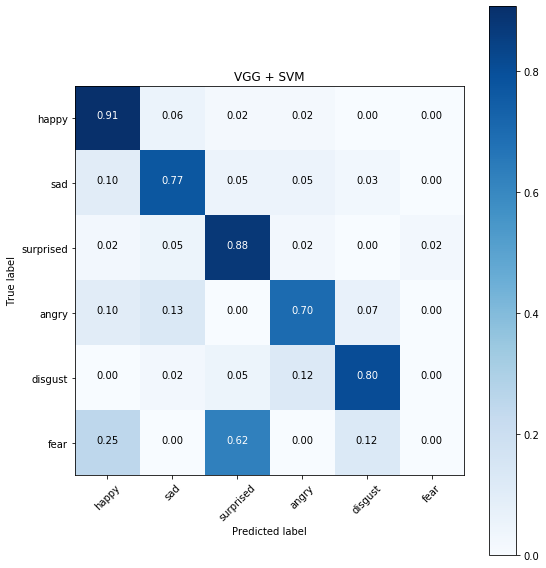

In [50]:
plot_confusion_matrix(cnf_mtrx_svm, 'VGG + SVM')

In [56]:
y_true = []
y_pred = []
for j in range(len(confCNN)):
    for i in range(confCNN[j][0].shape[0]):
        y_true.append(labels[np.argmax(np.asarray(confCNN[j][1][i]))])
        y_pred.append(labels[np.argmax(np.asarray(confCNN[j][0][i]))])
cnf_mtrx_CNN = confusion_matrix(y_true, y_pred, labels = labels)
cnf_mtrx_CNN = cnf_mtrx_CNN.astype('float') / cnf_mtrx_CNN.sum(axis=1)[:, np.newaxis]

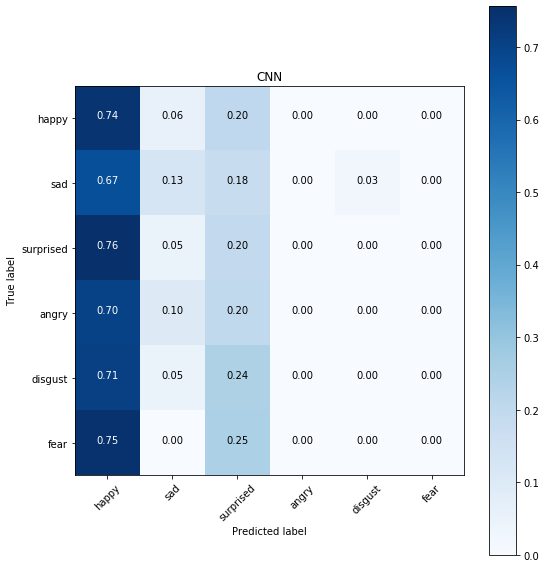

In [57]:
plot_confusion_matrix(cnf_mtrx_CNN, 'CNN')

In [86]:
def crossvalCK(datasetDir, modelFunc, preprocessFunc, preprocess = True):
    trainDir = os.path.join(datasetDir, preprocessedDir)
    if preprocess:
        ckFaces()
    
    length = len(os.listdir(trainDir))
    
    gtFile = os.path.join(datasetDir, 'gt.txt')
    trainTxt = open(gtFile, "r")
    trainData = {}
    
    for line in trainTxt:
        pair = line.split('-')
        trainData[pair[0]] = pair[1]
    
    Y = np.zeros(length)
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(os.listdir(trainDir)):
        image = io.imread(os.path.join(trainDir, f))
        imageArray = preprocessFunc(image.astype(np.float64))
        X[i] = imageArray.copy()
        Y[i] = trainData[f]
        
    kfold = StratifiedKFold(n_splits = n_splits, shuffle = True)
    scores = []
    conf = []
    
    for train, test in kfold.split(X, Y):
        model = modelFunc()
        optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        ytrain = np.zeros((len(Y[train]), len(labelsck)))
        for i in range(len(Y[train])):
            ytrain[i][int(Y[train][i])] = 1
        ytest = np.zeros((len(Y[test]), len(labelsck)))
        for i in range(len(Y[test])):
            ytest[i][int(Y[test][i])] = 1
        model.fit(X[train], ytrain, batch_size=batch_size, epochs=epochs)
        score = model.evaluate(X[test], ytest)
        yt = model.predict(X[test])
        ypred = np.zeros(yt.shape)
        for i in range(yt.shape[0]):
            ypred[i][np.argmax(yt[i])] = 1
        scores.append(score)
        conf.append([ypred.copy(), ytest.copy()])
        
    return scores, conf

In [93]:
def crossvalSVMCK(datasetDir, modelFunc, preprocessFunc, preprocess = True):
    trainDir = os.path.join(datasetDir, preprocessedDir)
    if preprocess:
        ckFaces()
    
    length = len(os.listdir(trainDir))
    
    gtFile = os.path.join(datasetDir, 'gt.txt')
    trainTxt = open(gtFile, "r")
    trainData = {}
    
    for line in trainTxt:
        pair = line.split('-')
        trainData[pair[0]] = pair[1]
    
    Y = np.zeros(length)
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(os.listdir(trainDir)):
        image = io.imread(os.path.join(trainDir, f))
        imageArray = preprocessFunc(image.astype(np.float64))
        X[i] = imageArray.copy()
        Y[i] = trainData[f]
        
    kfold = StratifiedKFold(n_splits = n_splits, shuffle = True)
         
    scores = []
    conf = []
    
    for train, test in kfold.split(X, Y):
        model = modelFunc()
            
        featuresTrain = model.predict(X[train])
        featuresTest = model.predict(X[test])
        
        '''ytall = np.zeros(Y[test].shape)
        for i in range(6):
            cls = svm.SVC(kernel='rbf',C=100.0,gamma=0.07,cache_size=800)
            ytrain = np.zeros(Y[train].shape)
            for j in range(Y[train].shape[0]):
                if Y[train][j] == i:
                    ytrain[j] = 1
            cls.fit(featuresTrain, ytrain)
            yt = cls.predict(featuresTest)
            for j in range(yt.shape[0]):
                if ytall[j] == 0:
                    ytall[j] = yt[j] * i'''
        cls = svm.SVC(kernel='rbf',C=100.0,gamma=0.07,cache_size=800)
        cls.fit(featuresTrain, Y[train])
        yt = cls.predict(featuresTest)
        score = cls.score(featuresTest, Y[test])
        scores.append(score)
        
        conf.append([yt.copy(), Y[test].copy()])
        
    return scores, conf

In [31]:
scoresVGGCK, confVGGCK = crossvalCK("ckplus", getVGGCKModel, preprocess_input_vgg)

NameError: name 'crossvalCK' is not defined

In [88]:
print(scoresVGGCK)
sum = 0.
for sc in scoresVGGCK:
    sum += sc[1]
print(sum / len(scoresVGGCK))

[[3.0505709719302048, 0.7313432844717112], [2.469700236818684, 0.8358208964120096], [2.2878327013841315, 0.8507462691015272], [1.8697041273117065, 0.859375], [3.3954752952821794, 0.7258064477674423]]
0.800618379550538


In [89]:
import matplotlib.pyplot as plt
def plot_confusion_matrix_ck(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labelsck))
    plt.xticks(tick_marks, labelsck, rotation=45)
    plt.yticks(tick_marks, labelsck)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.ylim(len(cm)-0.5, -0.5)
    plt.show()

0.800618379550538


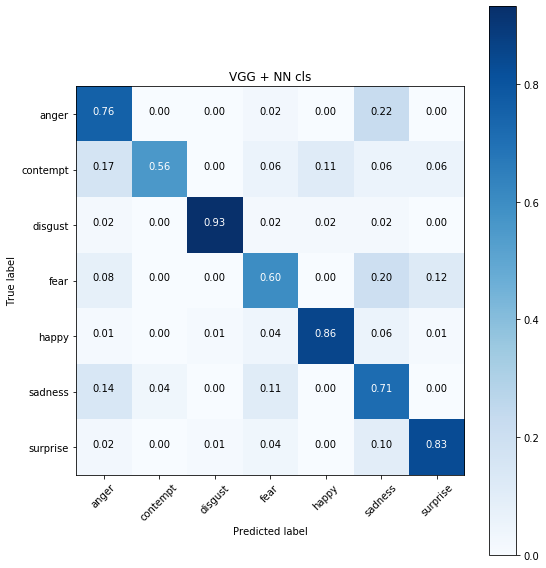

In [106]:
sum = 0.
for sc in scoresVGGCK:
    sum += sc[1]
print(sum / len(scoresVGGCK))

y_true = []
y_pred = []
for j in range(len(confVGGCK)):
    for i in range(confVGGCK[j][0].shape[0]):
        y_true.append(labelsck[np.argmax(np.asarray(confVGGCK[j][1][i]))])
        y_pred.append(labelsck[np.argmax(np.asarray(confVGGCK[j][0][i]))])
cnf_mtrx_ck = confusion_matrix(y_true, y_pred, labels = labelsck)
cnf_mtrx_ck = cnf_mtrx_ck.astype('float') / cnf_mtrx_ck.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix_ck(cnf_mtrx_ck, 'VGG + NN cls')

In [95]:
scoresVGGSVMCK, confVGGSVMCK = crossvalSVMCK("ckplus", getVGGSVMModel, preprocess_input_vgg)

0.8838634448724122


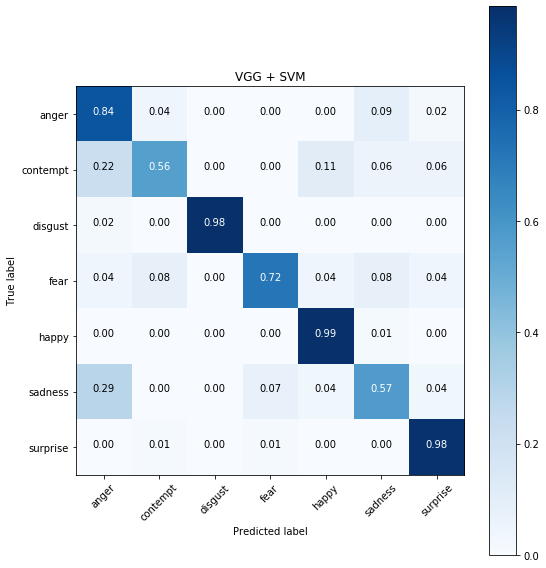

In [103]:
sum = 0.
for sc in scoresVGGSVMCK:
    sum += sc
print(sum / len(scoresVGGSVMCK))

y_true = []
y_pred = []
for j in range(len(confVGGSVMCK)):
    for i in range(confVGGSVMCK[j][0].shape[0]):
        y_true.append(labelsck[int(confVGGSVMCK[j][1][i])])
        y_pred.append(labelsck[int(confVGGSVMCK[j][0][i])])
cnf_mtrx_svm_ck = confusion_matrix(y_true, y_pred, labels = labelsck)
cnf_mtrx_svm_ck = cnf_mtrx_svm_ck.astype('float') / cnf_mtrx_svm_ck.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix_ck(cnf_mtrx_svm_ck, 'VGG + SVM')

In [40]:
labelsru = ['счастье', 'грусть', 'удивление', 'злость', 'отвращение', 'страх']
labelsckru = ['нейтрально', 'злость', 'презрение', 'отвращение', 'страх', 'счастье', 'грусть', 'удивление']

In [118]:
def classDistCK(datasetDir):
    gtFile = os.path.join(datasetDir, 'gt.txt')
    trainTxt = open(gtFile, "r")
    trainStat = [0] * len(labelsckru)
    
    for line in trainTxt:
        pair = line.split('-')
        trainStat[int(pair[1])] += 1
    
    fig1, ax1 = plt.subplots()
    ax1.pie(trainStat, labels=labelsckru, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

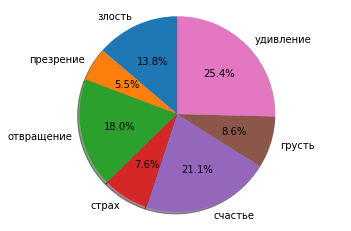

In [119]:
classDistCK('ckplus')

In [120]:
def classDistJAFFE(datasetDir):
    gtFile = 'gt.txt'
    trainTxt = open(gtFile, "r")
    trainStat = [0] * len(labelsru)
    
    
    for line in trainTxt:
        values = line.split(' ')
        fvalues = np.array(values[1:7])
        #trainData[values[0]] = [1 if v == max(fvalues) else 0 for v in fvalues]
        trainStat[np.argmax(fvalues)] += 1
    
    fig1, ax1 = plt.subplots()
    ax1.pie(trainStat, labels=labelsru, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

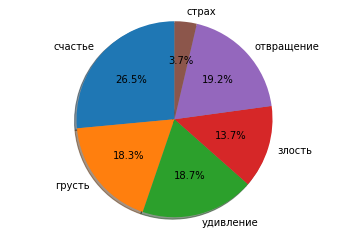

In [121]:
classDistJAFFE('jaffebase')

In [35]:
from datetime import timedelta
from datetime import datetime
import pickle

In [36]:
srcVideoDir = '3'
framesDir = os.path.join('frames', srcVideoDir)
videosDir = os.path.join('videos', srcVideoDir)
facesDir = os.path.join('faces', srcVideoDir)
labelsDir = os.path.join('labels', srcVideoDir)
labelsFileName = os.path.join(labelsDir, 'labels.txt')
redLabelsName = 'my_labels.txt'
baseFrameName = 'baseFrame.jpg'
startVideoTime = {'1':datetime(1900, 1, 1, hour = 14, minute = 40), '2':datetime(1900, 1, 1, hour = 14, minute = 35), '3':datetime(1900, 1, 1, hour = 14, minute = 35)}
fps = 30

In [37]:
def frameExtractionFromMultipleVideos(videoDir, framesDir, framesinmin):
    totalCount = 0
    for videoname in os.listdir(videoDir):
        video = cv2.VideoCapture(os.path.join(videoDir, videoname))
        success, image = video.read()
        success = True
        print("Frame saving from " + os.path.join(videoDir, videoname))
        fps = int(video.get(cv2.CAP_PROP_FPS))
        count = 0
        while success:
            cv2.imwrite(os.path.join(framesDir, "frame%d.jpg" % (totalCount + count)), image)
            count += fps * 60 // framesinmin    
            video.set(cv2.CAP_PROP_POS_FRAMES, count)
            success, image = video.read()
        totalCount += count

In [38]:
def setBaseFrame(framesDir, frameName, faces):
    frame = cv2.imread(os.path.join(framesDir, frameName))
    baseFacesList = []
    for i, result in enumerate(faces):
        x1, y1, x2, y2 = result['box']
        baseFacesList.append((x1, y1, x2, y2))
        cv2.rectangle(frame, (x1, y1), (x1 + x2, y1 + y2), (255, 0, 0), 2)
        cv2.putText(frame, str(i), (x1, y1 + y2), 1, 2, (0, 0, 255), 2) 
    cv2.imwrite(os.path.join('frames', srcVideoDir + baseFrameName), frame)
    return baseFacesList

In [467]:
#frame extraction
if not os.path.exists(framesDir):
    os.makedirs(framesDir)
frameExtractionFromMultipleVideos(videosDir, framesDir, 10)

Frame saving from videos\1\FHD0001.MOV
Frame saving from videos\1\FHD0002.MOV
Frame saving from videos\1\FHD0003.MOV
Frame saving from videos\1\FHD0004.MOV
Frame saving from videos\1\FHD0005.MOV
Frame saving from videos\1\FHD0006.MOV
Frame saving from videos\1\FHD0007.MOV
Frame saving from videos\1\FHD0008.MOV


In [45]:
#faces extraction
if not os.path.exists(facesDir):
    os.makedirs(facesDir)
facesDict = defaultdict(list)
maxFacesName = ''
maxFacesNum = 0
for f in os.listdir(framesDir):
    if f != preprocessedDir and f != baseFrameName:
        faceDetector(f, framesDir, facesDir, facesDict)
        facesNum = len(facesDict[f])
        if facesNum > maxFacesNum:
            maxFacesNum = facesNum
            maxFacesName = f

In [46]:
dbfile = open(os.path.join(labelsDir, 'bboxes'), 'wb') 
pickle.dump(facesDict, dbfile)                      
dbfile.close() 

In [43]:
dbfile = open(os.path.join(labelsDir, 'bboxes'), 'rb')      
facesDict = pickle.load(dbfile)
dbfile.close() 

In [521]:
print(maxFacesNum, maxFacesName)

23 frame26460.jpg


In [28]:
if not os.path.exists(labelsDir):
    os.makedirs(labelsDir)

In [29]:
baseFacesList = setBaseFrame(framesDir, maxFacesName, facesDict[maxFacesName])
dbfile = open(os.path.join(labelsDir, 'baseFaces'), 'wb') 
pickle.dump(baseFacesList, dbfile)                      
dbfile.close() 

In [27]:
dbfile = open(os.path.join(labelsDir, 'baseFaces'), 'rb')      
baseFacesList = pickle.load(dbfile)
dbfile.close() 

In [29]:
gtFile = open(labelsFileName, "a")
print("Type ground truth values in format: NUMBER ON BASE FRAME, START TIME, END TIME, ENGAGEMENT LABEL or anything else to stop")
newLabel = input()
while newLabel != 's' or newLabel != 'S':
    try:
        number, startTime, endTime, engagement = newLabel.split(',')
    except:
        break
    bbox = baseFacesList[int(number)]
    startFrame = int((datetime.strptime(startTime.strip(), "%H:%M") - startVideoTime[srcVideoDir]).total_seconds() * fps)
    endFrame = int((datetime.strptime(endTime.strip(), "%H:%M") - startVideoTime[srcVideoDir]).total_seconds() * fps)
    gtFile.write(f"{bbox} {startFrame} {endFrame} {engagement}\n")
    newLabel = input()
gtFile.close()

Type ground truth values in format: NUMBER ON BASE FRAME, START TIME, END TIME, ENGAGEMENT LABEL or anything else to stop
0, 15:00, 15:00, 0
8, 15:00, 15:00, 0
3, 15:00, 15:00, 0
2, 15:00, 15:00, 0
9, 15:00, 15:00, 0
11, 15:00, 15:00, 0
s


In [51]:
clsSVMprob = trainSVMFacesProb('ckplus', 'ckplus/gt.txt', getVGGSVMModel, preprocess_input_colored)

In [39]:
def predictSVMFacesProb(testDir, modelFunc, preprocessFunc, cls):
    featureModel = modelFunc()
    
    facesList = []
    
    for f in sorted(os.listdir(testDir)):
        facesList.append(Image.fromarray(cv2.imread(os.path.join(testDir, f))))
    
    length = len(facesList)
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(facesList):
        imageArray = preprocessFunc((np.asarray(f)).astype(np.float64))
        X[i] = imageArray.copy()
    
    print(X.shape)
    featuresTrain = featureModel.predict(X)
    print(featuresTrain.shape)
    Y = cls.predict_proba(featuresTrain)
    return Y

In [53]:
datasetPreds = predictSVMFacesProb(facesDir, getVGGSVMModel, preprocess_input_colored, clsSVMprob)

(11326, 224, 224, 3)
(11326, 512)


In [43]:
datasetClasses = []
for d in datasetPreds:
    datasetClasses.append(np.argmax(np.asarray(d)))
print(len(datasetClasses))

13151


In [45]:
#dataset metrics
metricsDict = defaultdict(lambda : defaultdict(int))
for i, f in enumerate(sorted(os.listdir(facesDir))):
    frameNumber = int(f.split('_')[0][5:])
    metricsDict[frameNumber][datasetClasses[i]] += 1

maxList = [0] * 7
maxFrameList = [0] * 7
for k in metricsDict:
    for y in metricsDict[k]:
        if metricsDict[k][y] > maxList[y]:
            maxFrameList[y] = k
            maxList[y] = metricsDict[k][y]

In [47]:
print(maxList)
print(maxFrameList)

[7, 0, 5, 1, 1, 1, 18]
[100980, 0, 130860, 6300, 140400, 98460, 23400]


In [46]:
datasetMediumPreds = [0.0] * 7
for d in datasetPreds:
    for i in range(7):
        datasetMediumPreds[i] += d[i]
for i in range(7):
    datasetMediumPreds[i] /= len(datasetPreds) * 1.0
print(datasetMediumPreds)

[0.25198720416051806, 0.013571732783022122, 0.17812165907637484, 0.03347091911846159, 0.022917697782437154, 0.03357657945909977, 0.4663542076200839]


In [580]:
myLabelsFileName = os.path.join(labelsDir, 'my_labels.txt')
gtFile = open(myLabelsFileName, "r")
engageTime = []
for line in gtFile:
    t = line.split(' ')
    for i in range(len(t)):
        t[i] = int(t[i])
    engageTime.append(t)
gtFile.close()

In [581]:
delta = 900
engagedPart = []
notEngagedPart = []
i = 0
for f in sorted(os.listdir(facesDir)):
    frameNumber = int(f.split('_')[0][5:])
    isEngaged = False
    for t in engageTime:
        if frameNumber > t[0] + delta and frameNumber < t[1] - delta:
            isEngaged = True
            break
    if isEngaged:
        engagedPart.append(datasetPreds[i])
    else:
        notEngagedPart.append(datasetPreds[i])
    i += 1

In [582]:
from scipy.stats import ttest_ind
print(len(engagedPart), len(notEngagedPart))
ttest_ind(engagedPart, notEngagedPart)

749 12072


Ttest_indResult(statistic=array([ 2.42569714, -0.05801621,  0.48334524, -2.21368638, -0.80119227,
        0.52061707, -1.48896456]), pvalue=array([0.01529273, 0.95373662, 0.62885888, 0.0268679 , 0.42303519,
       0.60264254, 0.1365213 ]))

In [610]:
gtFile = open(labelsFileName, "r")
labelsList = []
for line in gtFile:
    t = line.split(' ')
    l = [int(t[0][1:-1]), int(t[1][:-1]), int(t[2][:-1]), int(t[3][:-1])]
    labelsList.append([*getCenterFaceCoords(l), int(t[4]), int(t[5]), float(t[7])])
gtFile.close()

myLabelsFileName = os.path.join(labelsDir, 'my_labels.txt')
gtFile = open(myLabelsFileName, "r")
engageTime = []
for line in gtFile:
    t = line.split(' ')
    for i in range(len(t)):
        t[i] = int(t[i])
    engageTime.append(t)
gtFile.close()

In [40]:
def getCenterFaceCoords(l):
    return [l[0] + l[2] // 2, l[1] + l[3] // 2]

In [41]:
def getEngageTime(face, faces, engageTime):
    dist = abs(face[0] - faces[0][0]) + abs(face[1] - faces[0][1])
    coordsForGroup = faces[0][:2]
    resultList = [faces[0][2:]]
    for i, f in enumerate(faces):
        d = abs(face[0] - f[0]) + abs(face[1] - f[1])
        if d == dist:
            resultList.append(f[2:])
        if d < dist:
            dist = d
            resultList = [f[2:]]
            coordsForGroup = f[:2]
    filteredList = []
    if dist < 50:
        for r in resultList:
            if r[1] - r[0] < 27000:
                filteredList.append(r)
        for e in engageTime:
            filteredList.append([*e, 1.0])
        
    #возвращаются метки в порядке приоритета
    return filteredList, coordsForGroup

In [611]:
print(labelsList)
print(engageTime)

[[978, 629, 18000, 45000, 0.5], [978, 629, 90000, 108000, 0.8], [978, 629, 126000, 144000, 0.2], [822, 637, 0, 54000, 0.8], [822, 637, 54000, 117000, 0.5], [684, 670, 0, 162000, 0.8], [1144, 673, 63000, 72000, 0.8], [773, 635, 0, 162000, 0.5], [932, 653, 81000, 99000, 0.5], [932, 653, 135000, 144000, 0.4], [1764, 652, 9000, 12600, 0.8], [1764, 652, 36000, 39600, 0.8], [1764, 652, 86400, 90000, 0.8], [1764, 652, 99000, 108000, 0.8], [1552, 647, 9000, 27000, 0.8], [1552, 647, 27000, 45000, 0.8], [1084, 616, 18000, 36000, 0.3], [1084, 616, 81000, 99000, 0.6], [1257, 657, 0, 162000, 0.8], [1065, 626, 0, 162000, 0.2], [1599, 689, 0, 162000, 1.0], [269, 590, 9000, 18000, 0.4], [269, 590, 18000, 36000, 0.8], [269, 590, 54000, 72000, 0.8], [269, 590, 108000, 126000, 0.8], [411, 603, 18000, 36000, 1.0], [411, 603, 72000, 90000, 1.0], [411, 603, 126000, 144000, 1.0], [1432, 652, 0, 162000, 0.8], [191, 584, 25200, 30600, 0.0], [191, 584, 32400, 37800, 0.8], [191, 584, 102600, 106200, 0.8], [133, 

In [495]:
#new labeling technique
delta = 60
engagedPart = []
notEngagedPart = []
i = 0
for f in sorted(os.listdir(facesDir)):
    frameNumber = int(f.split('_')[0][5:])
    faceNumber = int(f.split('_')[1].split('.')[0])
    bbox = facesDict['frame' + str(frameNumber) + '.jpg'][faceNumber]['box']
    coords = getCenterFaceCoords(bbox)
    faceEngageTime, _ = getEngageTime(coords, labelsList, engageTime)
    
    isEngaged = False
    for t in faceEngageTime:
        if frameNumber > t[0] + delta and frameNumber < t[1] - delta and t[2] > 0.5:
            isEngaged = True
            break
    if isEngaged:
        engagedPart.append(datasetPreds[i])
    else:
        notEngagedPart.append(datasetPreds[i])
    i += 1

In [473]:
print(facesDict['frame0.jpg'])

[{'box': [769, 624, 42, 53], 'confidence': 0.9999854564666748, 'keypoints': {'left_eye': (786, 644), 'right_eye': (805, 644), 'nose': (799, 656), 'mouth_left': (787, 664), 'mouth_right': (804, 664)}}, {'box': [1399, 626, 38, 56], 'confidence': 0.9999603033065796, 'keypoints': {'left_eye': (1420, 645), 'right_eye': (1435, 647), 'nose': (1432, 657), 'mouth_left': (1418, 666), 'mouth_right': (1431, 668)}}, {'box': [409, 588, 29, 37], 'confidence': 0.9999120235443115, 'keypoints': {'left_eye': (421, 601), 'right_eye': (435, 603), 'nose': (428, 610), 'mouth_left': (419, 616), 'mouth_right': (431, 618)}}, {'box': [1664, 620, 42, 58], 'confidence': 0.9996740818023682, 'keypoints': {'left_eye': (1671, 644), 'right_eye': (1692, 645), 'nose': (1675, 657), 'mouth_left': (1669, 669), 'mouth_right': (1686, 670)}}, {'box': [867, 609, 23, 31], 'confidence': 0.9996215105056763, 'keypoints': {'left_eye': (882, 620), 'right_eye': (890, 621), 'nose': (890, 627), 'mouth_left': (880, 633), 'mouth_right': (

In [474]:
from scipy.stats import ttest_ind
print(len(engagedPart), len(notEngagedPart))
ttest_ind(engagedPart, notEngagedPart)

3990 9161


Ttest_indResult(statistic=array([ 0.26138355,  0.65072002, -2.52400465, -3.7073937 , -1.1018683 ,
       -0.81934649,  1.9614551 ]), pvalue=array([7.93800837e-01, 5.15238610e-01, 1.16143156e-02, 2.10263571e-04,
       2.70539102e-01, 4.12603606e-01, 4.98470269e-02]))

In [334]:
#LogReg

In [113]:
from sklearn.linear_model import LogisticRegression

In [540]:
X = notEngagedPart + engagedPart
Y = [0] * len(notEngagedPart) + [1] * len(engagedPart)

for i, x in enumerate(X):
    X[i] = [x[1], x[2], x[5]]

print(len(X))
print(len(Y))

print(X[0], Y[0])
print(X[-1], Y[-1])

logReg = LogisticRegression(class_weight='balanced').fit(X, Y)

13151
13151
[0.01407624411773259, 0.31841763324187256, 0.045458408804865943] 0
[0.005533379961601027, 0.04482834824546671, 0.013971671763513379] 1


C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [541]:
l = logReg.predict(X)
print(sum(l))

7323


In [542]:
logReg.score(X[11000:], Y[11000:])

0.5769409576940958

In [543]:
#SVM

In [544]:
emoSVM = svm.SVC(kernel = 'poly', C=100.0, gamma=0.07, cache_size=800, class_weight='balanced')
emoSVM.fit(X, Y)

SVC(C=100.0, cache_size=800, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.07, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [547]:
s = emoSVM.predict(X)

In [546]:
emoSVM.score(X, Y)

0.8302030263858262

In [ ]:
X_test = notEngagedPart + engagedPart
Y_test = [0] * len(notEngagedPart) + [1] * len(engagedPart)
for i, x in enumerate(X_test):
    X_test[i] = [x[2], x[3], x[6]]

In [ ]:
emoSVM.score(X_test[11000:], Y_test[11000:])

In [567]:
#without emotions

In [43]:
def trainEngagementSVM(datasetDir, Y, modelFunc, preprocessFunc, preprocess = True):
    length = len(os.listdir(datasetDir))
    
    X = np.zeros((length, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(sorted(os.listdir(datasetDir))):
        image = io.imread(os.path.join(datasetDir, f))
        imageArray = preprocessFunc(image.astype(np.float64))
        X[i] = imageArray.copy()
    
    featureModel = modelFunc()
    featuresTrain = featureModel.predict(X)
    
    c = svm.SVC(kernel='rbf', C=100.0, gamma=0.07, cache_size=800)
    c.fit(featuresTrain, Y)
    
    return c

In [612]:
Y = []

for f in sorted(os.listdir(facesDir)):
    frameNumber = int(f.split('_')[0][5:])
    faceNumber = int(f.split('_')[1].split('.')[0])
    bbox = facesDict['frame' + str(frameNumber) + '.jpg'][faceNumber]['box']
    coords = getCenterFaceCoords(bbox)
    faceEngageTime, _ = getEngageTime(coords, labelsList, engageTime)
    
    isEngaged = False
    for t in faceEngageTime:
        if frameNumber > t[0] + delta and frameNumber < t[1] - delta and t[2] > 0.5:
            isEngaged = True
            break
    if isEngaged:
        Y.append(1)
    else:
        Y.append(0)

In [613]:
print(len(Y))

13151


In [599]:
engSVM = trainEngagementSVM(facesDir, Y, getVGGSVMModel, preprocess_input_colored)

In [66]:
def scoreEngagementSVM(testDir, Y, modelFunc, preprocessFunc, c):
    featureModel = modelFunc()
    
    facesList = []
    Y_score = []
    
    for f in sorted(os.listdir(testDir)):
        facesList.append(Image.fromarray(cv2.imread(os.path.join(testDir, f))))
    
    length = len(facesList)
    X_score = np.zeros((length - 10000, *faceSize, 3), dtype=np.float64)
    
    for i, f in enumerate(facesList):
        if i >= 10000:
            imageArray = preprocessFunc((np.asarray(f)).astype(np.float64))
            X_score[i - 10000] = imageArray.copy()
            Y_score.append(Y[i])
    
    featuresTrain = featureModel.predict(X_score)
    print(featuresTrain.shape)
    return c.score(featuresTrain, Y_score)

In [621]:
scoreEngagementSVM(facesDir, Y, getVGGSVMModel, preprocess_input_colored, engSVM)

(3151, 512)


0.8219612821326563

In [56]:
#CROSS-VAL ON ALL FRAMES

In [42]:
delta = 0
engagedPart = []
notEngagedPart = []
engagedPartGrouping = []
notEngagedPartGrouping = []
engagedFrameNumbers = []
notEngagedFrameNumbers = []
engagedExpertLabels = []
notEngagedExpertLabels = []

clsSVMprob = trainSVMFacesProb('ckplus', 'ckplus/gt.txt', getVGGSVMModel, preprocess_input_colored)

for n in [2]:
    srcVideoDir = str(n + 1)
    framesDir = os.path.join('frames', srcVideoDir)
    videosDir = os.path.join('videos', srcVideoDir)
    facesDir = os.path.join('faces', srcVideoDir)
    labelsDir = os.path.join('labels', srcVideoDir)
    labelsFileName = os.path.join(labelsDir, 'labels.txt')
    
    dbfile = open(os.path.join(labelsDir, 'bboxes'), 'rb')      
    facesDict = pickle.load(dbfile)
    dbfile.close() 
    
    
    print(facesDir)
    datasetPreds = predictSVMFacesProb(facesDir, getVGGSVMModel, preprocess_input_colored, clsSVMprob)
    
    gtFile = open(labelsFileName, "r")
    labelsList = []
    for line in gtFile:
        t = line.split(' ')
        l = [int(t[0][1:-1]), int(t[1][:-1]), int(t[2][:-1]), int(t[3][:-1])]
        labelsList.append([*getCenterFaceCoords(l), int(t[4]), int(t[5]), float(t[7])])
    gtFile.close()

    redLabelsFileName = os.path.join(labelsDir, redLabelsName)
    gtFile = open(redLabelsFileName, "r")
    engageTime = []
    for line in gtFile:
        t = line.split(' ')
        for i in range(len(t)):
            t[i] = int(t[i])
        engageTime.append(t)
    gtFile.close()
    
    gtFile = open(myLabelsFileName, "r")
    expertTime = []
    for line in gtFile:
        t = line.split(' ')
        for i in range(len(t)):
            t[i] = int(t[i])
        expertTime.append(t)
    gtFile.close()

    i = 0
    for f in sorted(os.listdir(facesDir)):
        frameNumber = int(f.split('_')[0][5:])
        faceNumber = int(f.split('_')[1].split('.')[0])
        bbox = facesDict['frame' + str(frameNumber) + '.jpg'][faceNumber]['box']
        coords = getCenterFaceCoords(bbox)
        faceEngageTime, groupPair = getEngageTime(coords, labelsList, engageTime)
        
        
        if faceEngageTime:
            isEngaged = False
            isExpertEngaged = False
            for t in expertTime:
                if frameNumber >= t[0] and frameNumber <= t[1]:
                    isExpertEngaged = True
                    break
            for t in faceEngageTime:
                if frameNumber > t[0] + delta and frameNumber < t[1] - delta and t[2] > 0.5:
                    isEngaged = True
                    break
            if isEngaged:
                engagedPart.append(datasetPreds[i])
                engagedPartGrouping.append(groupPair)
                engagedFrameNumbers.append(frameNumber)
                if isExpertEngaged:
                    engagedExpertLabels.append(1)
                else:
                    engagedExpertLabels.append(0)
            else:
                notEngagedPart.append(datasetPreds[i])
                notEngagedPartGrouping.append(groupPair)
                notEngagedFrameNumbers.append(frameNumber)
                if isExpertEngaged:
                    notEngagedExpertLabels.append(1)
                else:
                    notEngagedExpertLabels.append(0)
        i += 1

faces\3
(12821, 224, 224, 3)
(12821, 2048)


In [43]:
print(len(engagedPart), len(notEngagedPart))

680 4013


In [44]:
from scipy.stats import ttest_ind
ttest_ind(engagedPart, notEngagedPart)

Ttest_indResult(statistic=array([ 0.71826961,  1.85777788, -3.01073025,  1.35040835, -0.42066481,
       -0.04345531,  1.1671576 ]), pvalue=array([0.47262683, 0.06326318, 0.00262008, 0.17695018, 0.67401913,
       0.96534043, 0.24320605]))

In [45]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [46]:
from sklearn.linear_model import LogisticRegression

X = notEngagedPart + engagedPart
Y = [0] * len(notEngagedPart) + [1] * len(engagedPart)
G = notEngagedPartGrouping + engagedPartGrouping
E = engagedExpertLabels + notEngagedExpertLabels

In [47]:
FN = engagedFrameNumbers + notEngagedFrameNumbers

In [48]:
for i, g in enumerate(G):
    G[i] = g[0] * g[0] + g[1] * g[1]

In [49]:
print(len(X), len(Y), len(G), len(E), len(FN))

4693 4693 4693 4693 4693


In [50]:
def plotROCAUC(aucList, fprList, tprList, outputName):
    plt.figure()
    lw = 2
    #plt.plot(sum(fprList) / len(fprList), sum(tprList) / len(tprList), color='darkorange',
    #         lw=lw, label='ROC curve (area = %0.3f)' % (sum(aucList) / len(aucList)))
    plt.plot(fprList, tprList, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % (max(aucList)))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.savefig(outputName, bbox_inches = 'tight')
    plt.show()

In [ ]:
from sklearn.model_selection import GroupKFold

logRegScores = []
auclogRegScores = []
fprlogReg = []
tprlogReg = []

gkf = GroupKFold(n_splits = 6)
for train_index, test_index in gkf.split(X, Y, groups = G):
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    Y_train, Y_test = np.array(Y)[train_index], np.array(Y)[test_index]
    logReg = LogisticRegression(C = 10, class_weight = 'balanced').fit(X_train, Y_train)
    logRegScores.append(logReg.score(X_test, Y_test))
    fpr_t, tpr_t, _ = roc_curve(Y_test, logReg.predict_proba(X_test)[:, 1])
    auclogRegScores.append(auc(fpr_t, tpr_t))
    fprlogReg.append(fpr_t)
    tprlogReg.append(tpr_t)

In [ ]:
print(auclogRegScores)

In [ ]:
print(sum(logRegScores) / len(logRegScores))

In [ ]:
plotROCAUC(auclogRegScores, fprlogReg[1], tprlogReg[1], 'rocLogRegEmotions.png')

In [ ]:
svmScores = []
aucsvmScores = []
fprsvm = []
tprsvm = []

gkf = GroupKFold(n_splits = 6)
for train_index, test_index in gkf.split(X, Y, groups = G):
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    Y_train, Y_test = np.array(Y)[train_index], np.array(Y)[test_index]
    emoSVM = svm.SVC(kernel = 'rbf', C = 10, gamma = 0.07, class_weight = 'balanced', probability = True).fit(X_train, Y_train)
    svmScores.append(emoSVM.score(X_test, Y_test))
    fpr_t, tpr_t, _ = roc_curve(Y_test, emoSVM.predict_proba(X_test)[:, 1])
    aucsvmScores.append(auc(fpr_t, tpr_t))
    fprsvm.append(fpr_t)
    tprsvm.append(tpr_t)

In [ ]:
print(aucsvmScores)

In [ ]:
print(sum(svmScores) / len(svmScores))

In [ ]:
plotROCAUC(aucsvmScores, fprsvm[2], tprsvm[2], 'rocSVMEmotions.png')

In [51]:
X_svm = []
i = 0

for n in [2]:
    srcVideoDir = str(n + 1)
    framesDir = os.path.join('frames', srcVideoDir)
    videosDir = os.path.join('videos', srcVideoDir)
    facesDir = os.path.join('faces', srcVideoDir)
    labelsDir = os.path.join('labels', srcVideoDir)
    labelsFileName = os.path.join(labelsDir, 'labels.txt')
    
    dbfile = open(os.path.join(labelsDir, 'bboxes'), 'rb')      
    facesDict = pickle.load(dbfile)
    dbfile.close() 
    
    gtFile = open(labelsFileName, "r")
    labelsList = []
    for line in gtFile:
        t = line.split(' ')
        l = [int(t[0][1:-1]), int(t[1][:-1]), int(t[2][:-1]), int(t[3][:-1])]
        labelsList.append([*getCenterFaceCoords(l), int(t[4]), int(t[5]), float(t[7])])
    gtFile.close()

    redLabelsFileName = os.path.join(labelsDir, redLabelsName)
    gtFile = open(redLabelsFileName, "r")
    engageTime = []
    for line in gtFile:
        t = line.split(' ')
        for i in range(len(t)):
            t[i] = int(t[i])
        engageTime.append(t)
    gtFile.close()
    
    for f in sorted(os.listdir(facesDir)):
        frameNumber = int(f.split('_')[0][5:])
        faceNumber = int(f.split('_')[1].split('.')[0])
        bbox = facesDict['frame' + str(frameNumber) + '.jpg'][faceNumber]['box']
        coords = getCenterFaceCoords(bbox)
        faceEngageTime, groupPair = getEngageTime(coords, labelsList, engageTime)
        if faceEngageTime:
            image = io.imread(os.path.join(facesDir, f))
            imageArray = preprocess_input_colored(image.astype(np.float64))
            X_svm.append(imageArray.copy())

In [66]:
#get and save features
featureModel = getVGGSVMModel()
featuresSVM = featureModel.predict(np.array(X_svm))

In [67]:
print(len(featuresSVM))

9504


In [68]:
dbfile = open(os.path.join(labelsDir, 'features'), 'wb') 
pickle.dump(featuresSVM, dbfile)                      
dbfile.close()

In [52]:
dbfile = open(os.path.join(labelsDir, 'features'), 'rb')      
featuresSVM = pickle.load(dbfile)
dbfile.close() 

In [65]:
engagedPart = []
notEngagedPart = []
engagedPartGrouping = []
notEngagedPartGrouping = []

In [66]:
from sklearn.model_selection import GroupKFold

englogRegScores = []
aucenglogRegScores = []
fprenglogReg = []
tprenglogReg = []
aucexpertlogReg = []
fprexpertlogReg = []
tprexpertlogReg = []
avgeng = defaultdict(int)
numeng = defaultdict(int)
experteng = defaultdict(int)

gkf = GroupKFold(n_splits = 6)
for train_index, test_index in gkf.split(featuresSVM, Y, groups = G):
    X_train, X_test = np.array(featuresSVM)[train_index], np.array(featuresSVM)[test_index]
    Y_train, Y_test = np.array(Y)[train_index], np.array(Y)[test_index]
    englogReg = LogisticRegression(C = 10000, class_weight = 'balanced').fit(X_train, Y_train)
    englogRegScores.append(englogReg.score(X_test, Y_test))
    probs = englogReg.predict_proba(X_test)[:, 1]
    fpr_t, tpr_t, _ = roc_curve(Y_test, probs)
    fpr_e, tpr_e, _ = roc_curve(np.array(E)[test_index], probs)
    aucenglogRegScores.append(auc(fpr_t, tpr_t))
    fprenglogReg.append(fpr_t)
    tprenglogReg.append(tpr_t)
    aucexpertlogReg.append(auc(fpr_e, tpr_e))
    fprexpertlogReg.append(fpr_e)
    tprexpertlogReg.append(tpr_e)    
    i = 0
    for t in np.array(FN)[test_index]:
        avgeng[t] += probs[i]
        experteng[t] = Y_test[i]
        numeng[t] += 1
        i += 1

C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: 

In [67]:
print(sum(englogRegScores) / len(englogRegScores))

0.7175234352770152


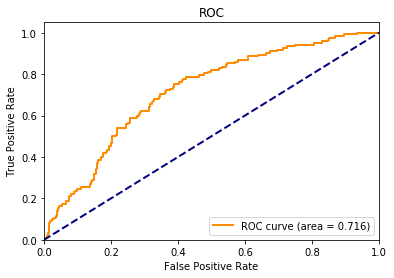

In [71]:
plotROCAUC(aucenglogRegScores, fprenglogReg[4], tprenglogReg[4], 'rocLogRegEngagement.png')

In [137]:
avgengList = []
expertengList = []

for k in avgeng:
    avgengList.append(avgeng[k] / numeng[k])
    expertengList.append(experteng[k])

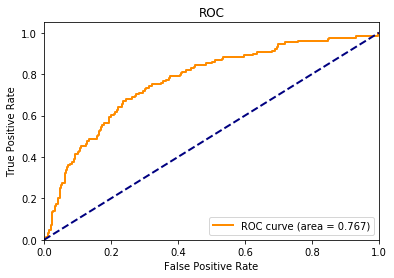

In [139]:
fpr_e, tpr_e, _ = roc_curve(expertengList, avgengList)

plotROCAUC([auc(fpr_e, tpr_e)], fpr_e, tpr_e, 'rocAvgLogReg.png')

In [140]:
from sklearn.model_selection import GroupKFold

engSVMScores = []
aucengSVMScores = []
fprengSVM = []
tprengSVM = []
avgeng = defaultdict(int)
numeng = defaultdict(int)
experteng = defaultdict(int)

featureModel = getVGGSVMModel()
        
gkf = GroupKFold(n_splits = 6)
for train_index, test_index in gkf.split(featuresSVM, Y, groups = G):
    X_train, X_test = np.array(featuresSVM)[train_index], np.array(featuresSVM)[test_index]
    Y_train, Y_test = np.array(Y)[train_index], np.array(Y)[test_index]
    engSVM = svm.SVC(kernel='rbf', C = 100, gamma=0.07, class_weight = 'balanced', probability = True).fit(X_train, Y_train)
    engSVMScores.append(engSVM.score(X_test, Y_test))
    probs = engSVM.predict_proba(X_test)[:, 1]
    fpr_t, tpr_t, _ = roc_curve(Y_test, probs)
    aucengSVMScores.append(auc(fpr_t, tpr_t))
    fprengSVM.append(fpr_t)
    tprengSVM.append(tpr_t)
    i = 0
    for t in np.array(FN)[test_index]:
        avgeng[t] += probs[i]
        experteng[t] = Y_test[i]
        numeng[t] += 1
        i += 1

In [141]:
print(sum(engSVMScores) / len(engSVMScores))

0.6552826223065923


In [142]:
print(aucengSVMScores)

[0.6609807774980041, 0.6097025180482707, 0.655549832603657, 0.6296478957436634, 0.7194972329539522, 0.6017988100179881]


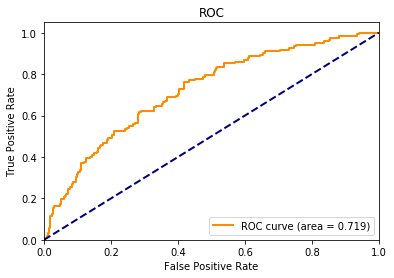

In [143]:
plotROCAUC(aucengSVMScores, fprengSVM[4], tprengSVM[4], 'rocSVMEngagement.png')

In [144]:
avgengList = []
expertengList = []

for k in avgeng:
    avgengList.append(avgeng[k] / numeng[k])
    expertengList.append(experteng[k])

In [58]:
fpr_e, tpr_e, _ = roc_curve(expertengList, avgengList)

plotROCAUC([auc(fpr_e, tpr_e)], fpr_e, tpr_e, 'rocAvgLogReg2.png')

NameError: name 'expertengList' is not defined

In [44]:
#DAiSEE

In [70]:
import csv

In [71]:
daiseePath = 'D:\Files\Datasets\DAiSEE'
daiseeLabelsPath = 'D:\Files\Datasets\DAiSEE\Labels\TrainLabels.csv'

In [72]:
dictLabels = {}

In [73]:
with open(daiseeLabelsPath) as csvLabels:
    reader = csv.reader(csvLabels, delimiter = ',')
    for i, row in enumerate(reader):
        if i > 0:
            dictLabels[row[0]] = int(row[2]) + 9 - int(row[1]) - int(row[3]) - int(row[4]) #engagement label in row[2]

In [74]:
X_DAiSEE = np.zeros((5358, *faceSize, 3))
Y_DAiSEE = []

In [75]:
detector = MTCNN()
i = 0
for f in os.listdir(os.path.join(daiseePath, 'DataSet', 'Train')):
    for ff in os.listdir(os.path.join(daiseePath, 'DataSet', 'Train', f)):
        for video in os.listdir(os.path.join(daiseePath, 'DataSet', 'Train', f, ff)):
            if video in dictLabels:
                videoSrc = cv2.VideoCapture(os.path.join(daiseePath, 'DataSet', 'Train', f, ff, video))
                videoLength = int(videoSrc.get(cv2.CAP_PROP_FRAME_COUNT))
                for i in range(1, 2):
                    videoSrc.set(cv2.CAP_PROP_POS_FRAMES, videoLength * i // 2)
                    success, image = videoSrc.read()
                    faces = detector.detect_faces(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                    if (len(faces) > 0):
                        x1, y1, x2, y2 = faces[0]['box']
                        cropped = Image.fromarray(image).crop((x1, y1, x1 + x2, y1 + y2))
                        cropped = cropped.resize(faceSize)
                        X_DAiSEE[i] = preprocess_input_colored(np.array(cropped).astype(np.float64))
                        i += 1
                        Y_DAiSEE.append(dictLabels[video])

In [76]:
for i, y in enumerate(Y_DAiSEE):
    Y_DAiSEE[i] = float(y) / 16.0

In [77]:
print(len(Y_DAiSEE))

5358


In [78]:
for i, y in enumerate(Y_DAiSEE):
    if y < 0.51:
        Y_DAiSEE[i] = 0
    else:
        Y_DAiSEE[i] = 1

In [93]:
featureModel = getVGGSVMModel()
featuresTrain = featureModel.predict(X_DAiSEE)

daiseeSVM = svm.SVC(kernel='rbf', C = 1, gamma=0.07, class_weight = 'balanced', probability = True)
daiseeSVM.fit(featuresTrain, Y_DAiSEE)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.07, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [94]:
print(featuresTrain.shape)

(5358, 2048)


In [93]:
featuresTrain = []
X_DAiSEE = []
Y_DAiSEE = []

In [95]:
print(featuresSVM.shape)
print(len(Y))

(5740, 2048)
5740


In [69]:
daiseeSVMScores = []
aucdaiseeSVMScores = []
fprdaiseeSVM = []
tprdaiseeSVM = []

In [ ]:
daiseeSVMScores.append(daiseeSVM.score(featuresSVMX[:, 0], Y))
fpr_t, tpr_t, _ = roc_curve(Y, daiseeSVM.predict_proba(featuresSVMX[:, 0])[:, 1])
aucdaiseeSVMScores.append(auc(fpr_t, tpr_t))
fprdaiseeSVM.append(fpr_t)
tprdaiseeSVM.append(tpr_t)

In [134]:
from sklearn.base import clone

daiseeSVMScores = []
aucdaiseeSVMScores = []
fprdaiseeSVM = []
tprdaiseeSVM = []

gkf = GroupKFold(n_splits = 6)
for train_index, test_index in gkf.split(featuresSVM, Y, groups = G):
    X_train, X_test = np.array(featuresSVM)[train_index], np.array(featuresSVM)[test_index]
    Y_train, Y_test = np.array(Y)[train_index], np.array(Y)[test_index]
    c = clone(daiseeSVM)
    c.fit(X_train, Y_train)
    daiseeSVMScores.append(c.score(featuresSVM, Y))
    fpr_t, tpr_t, _ = roc_curve(Y, c.predict_proba(featuresSVM)[:, 1])
    aucdaiseeSVMScores.append(auc(fpr_t, tpr_t))
    fprdaiseeSVM.append(fpr_t)
    tprdaiseeSVM.append(tpr_t)

KeyboardInterrupt: 

In [83]:
def getVGGFCNModel():
    features_model = VGGFace(model='senet50', include_top = False, input_shape = (*faceSize, 3), pooling = 'avg')
    l = features_model.output
    #l = Flatten()(l)
    l = Dense(1024, kernel_regularizer=l2(0.003))(l)
    l = LeakyReLU()(l)
    l = Dropout(0.5)(l)
    l = Dense(1024, kernel_regularizer=l2(0.003))(l)
    l = LeakyReLU()(l)
    l = Dense(1, activation='softmax')(l)
    model = Model(inputs=features_model.input, outputs=l)
    for l in features_model.layers:
        l.trainable = False
    return model

In [84]:
daiseeFCN = getVGGFCNModel()

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
daiseeFCN.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
daiseeFCN.fit(X_DAiSEE, Y_DAiSEE, batch_size=batch_size, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
5358/5358 [==============================] - 25s 5ms/step - loss: 0.4962 - acc: 0.7951
Epoch 2/10
5358/5358 [==============================] - 18s 3ms/step - loss: 0.2049 - acc: 0.7951
Epoch 3/10
5358/5358 [==============================] - 17s 3ms/step - loss: 0.2049 - acc: 0.7951
Epoch 4/10
5358/5358 [==============================] - 17s 3ms/step - loss: 0.2049 - acc: 0.7951
Epoch 5/10
5358/5358 [==============================] - 17s 3ms/step - loss: 0.2049 - acc: 0.7951
Epoch 6/10
5358/5358 [==============================] - 19s 3ms/step - loss: 0.2049 - acc: 0.7951
Epoch 7/10
5358/5358 [==============================] - 19s 4ms/step - loss: 0.2049 - acc: 0.7951
Epoch 8/10
5358/5358 [==============================] - 18s 3ms/step - loss: 0.2049 - acc: 0.7951
Epoch 9/10
5358/5358 [==============================] - 18s 3ms/step - loss: 0.2049 - acc: 0.7951
Epoch 10/10
5358/5358 [==============================] - 18s 3ms/step 

In [91]:
daiseeSVMScores = []
aucdaiseeSVMScores = []
fprdaiseeSVM = []
tprdaiseeSVM = []
i = 0
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits = 6)
for train_index, test_index in gkf.split(featuresSVM, Y, groups = G):
    if i == 0:
        X_train, X_test = np.array(X_svm)[train_index], np.array(X_svm)[test_index]
        Y_train, Y_test = np.array(Y)[train_index], np.array(Y)[test_index]
        optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
        daiseeFCN.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
        daiseeFCN.fit(X_train, Y_train, batch_size=batch_size, epochs=10)
        #daiseeSVMScores.append(daiseeFCN.score(X_svm, Y))
        fpr_t, tpr_t, _ = roc_curve(Y, daiseeFCN.predict(np.array(X_svm)))
        aucdaiseeSVMScores.append(auc(fpr_t, tpr_t))
        fprdaiseeSVM.append(fpr_t)
        tprdaiseeSVM.append(tpr_t)
        i += 1

Epoch 1/10
3684/3684 [==============================] - 27s 7ms/step - loss: 0.8567 - acc: 0.1433
Epoch 2/10
3684/3684 [==============================] - 12s 3ms/step - loss: 0.8567 - acc: 0.1433
Epoch 3/10
3684/3684 [==============================] - 12s 3ms/step - loss: 0.8567 - acc: 0.1433
Epoch 4/10
2736/3684 [=====================>........] - ETA: 3s - loss: 0.8564 - acc: 0.1436

KeyboardInterrupt: 

In [ ]:
plotROCAUC(aucdaiseeSVMScores, fprdaiseeSVM[0], tprdaiseeSVM[0], 'rocSVMDAiSEE.png')

In [ ]:
#get examples

In [67]:
engSVMtest = svm.SVC(kernel='rbf', C = 100, gamma=0.07, class_weight = 'balanced', probability = True).fit(featuresSVM, Y)

In [68]:
Y_result = engSVMtest.predict_proba(featuresSVM)

In [69]:
print(Y_result)

[[0.89121792 0.10878208]
 [0.76777436 0.23222564]
 [0.61747492 0.38252508]
 ...
 [0.61316347 0.38683653]
 [0.70468065 0.29531935]
 [0.4745279  0.5254721 ]]


In [70]:
facesResultList = []

for n in [0]:
    srcVideoDir = str(n + 1)
    framesDir = os.path.join('frames', srcVideoDir)
    videosDir = os.path.join('videos', srcVideoDir)
    facesDir = os.path.join('faces', srcVideoDir)
    labelsDir = os.path.join('labels', srcVideoDir)
    labelsFileName = os.path.join(labelsDir, 'labels.txt')
    
    dbfile = open(os.path.join(labelsDir, 'bboxes'), 'rb')      
    facesDict = pickle.load(dbfile)
    dbfile.close() 
    
    gtFile = open(labelsFileName, "r")
    labelsList = []
    for line in gtFile:
        t = line.split(' ')
        l = [int(t[0][1:-1]), int(t[1][:-1]), int(t[2][:-1]), int(t[3][:-1])]
        labelsList.append([*getCenterFaceCoords(l), int(t[4]), int(t[5]), float(t[7])])
    gtFile.close()

    redLabelsFileName = os.path.join(labelsDir, redLabelsName)
    gtFile = open(redLabelsFileName, "r")
    engageTime = []
    for line in gtFile:
        t = line.split(' ')
        for i in range(len(t)):
            t[i] = int(t[i])
        engageTime.append(t)
    gtFile.close()
    
    for f in sorted(os.listdir(facesDir)):
        frameNumber = int(f.split('_')[0][5:])
        faceNumber = int(f.split('_')[1].split('.')[0])
        bbox = facesDict['frame' + str(frameNumber) + '.jpg'][faceNumber]['box']
        coords = getCenterFaceCoords(bbox)
        faceEngageTime, groupPair = getEngageTime(coords, labelsList, engageTime)
        if faceEngageTime:
            facesResultList.append(f)

In [80]:
NotEngResultList = []
EngResultList = []

for i, y in enumerate(Y_result):
    if y[0] > 0.97:
        NotEngResultList.append(facesResultList[i])
    if y[1] > 0.7:
        EngResultList.append(facesResultList[i])

In [81]:
print(NotEngResultList)

['frame110340_6.jpg', 'frame141300_5.jpg', 'frame3600_8.jpg']


In [82]:
print(EngResultList)

['frame117720_16.jpg', 'frame129060_4.jpg', 'frame129960_5.jpg', 'frame131940_14.jpg', 'frame132480_14.jpg', 'frame27360_2.jpg', 'frame37440_7.jpg', 'frame53460_2.jpg', 'frame54540_2.jpg', 'frame58680_9.jpg', 'frame59940_12.jpg', 'frame60480_13.jpg', 'frame60660_9.jpg', 'frame62100_7.jpg', 'frame63360_9.jpg', 'frame64980_16.jpg', 'frame72900_0.jpg', 'frame75240_4.jpg', 'frame75420_6.jpg', 'frame75600_7.jpg', 'frame76320_4.jpg', 'frame76680_4.jpg', 'frame77940_1.jpg', 'frame78660_10.jpg', 'frame8100_4.jpg', 'frame8100_5.jpg', 'frame81180_5.jpg', 'frame81540_8.jpg', 'frame82800_9.jpg', 'frame8280_16.jpg', 'frame83340_5.jpg', 'frame84420_13.jpg', 'frame84780_10.jpg', 'frame9180_15.jpg', 'frame92160_12.jpg', 'frame92520_9.jpg', 'frame93420_9.jpg', 'frame9720_12.jpg', 'frame97920_5.jpg']
